# Time Series Modeling: Spain Energy Data

## Prepare Notebook

**Read in libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Notebook Preferences**

In [29]:
#Set Pandas preferenes
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Set style for matplotlib and fontdict for plots
plt.style.use('seaborn-dark')
title_dict= {'fontsize':18,
            'style': 'italic',
            'fontweight': 'semibold'}

label_dict= {'fontsize':14,
             'fontweight': 'semibold'}

#Surpress annoying warnings
warnings.filterwarnings('ignore')

**Read in data**

In [25]:
#Set path to data
path = r'\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\03_Processed_Data'

#Read in training and test data
X_train = pd.read_csv(path + '/2020_0624_Training_Data.csv', index_col=0)
X_test = pd.read_csv(path + '/2020_0624_Test_Data.csv', index_col=0)

#Read in price forecasts data
price_forecasts = pd.read_csv(path + '/2020_0620_Data_Price_Forecasts.csv', index_col=0)

**Preview Data**

In [5]:
print('Training data shape:', X_train.shape)
display(X_train.head())

print('\nTest data shape:',X_test.shape)
display(X_test.head())

print('\nPrice forecasts shape:',price_forecasts.shape)
display(price_forecasts.head())

Training data shape: (29789, 20)


,generation fossil gas,generation fossil gas season,generation fossil gas stationary,generation fossil gas trend,generation fossil hard coal,generation fossil hard coal season,generation fossil hard coal stationary,generation fossil hard coal trend,generation hydro pumped storage consumption,generation hydro pumped storage consumption season,generation hydro pumped storage consumption stationary,generation hydro pumped storage consumption trend,price actual,price actual season,price actual stationary,price actual trend,total load actual,total load actual season,total load actual stationary,total load actual trend
date_time,,,,,,,,,,,,,,,,,,,,
2015-01-01 12:00:00,3784.0,383.381984,-821.652818,4222.270833,4220.0,181.521023,-134.521023,4173.000000,972.0,-238.648681,131.336181,1079.3125,60.12,3.750959,-5.750750,62.119792,24133.0,2352.743184,-2151.597351,23931.854167
2015-01-01 13:00:00,3754.0,402.106788,-788.106788,4140.000000,4404.0,219.642515,159.169985,4025.187500,922.0,-269.700629,81.075629,1110.6250,62.05,3.292118,-3.198368,61.956250,24713.0,2856.356263,-2121.835430,23978.479167
2015-01-01 14:00:00,3779.0,363.470608,-633.241441,4048.770833,4256.0,220.103358,159.104975,3876.791667,941.0,-254.936512,30.936512,1165.0000,62.06,2.675646,-2.233563,61.617917,24672.0,3004.248460,-2332.248460,24000.000000
2015-01-01 15:00:00,3708.0,299.567702,-568.192702,3976.625000,4038.0,198.556871,101.672295,3737.770833,1069.0,-215.064849,50.314849,1233.7500,59.76,1.874951,-3.437243,61.322292,23528.0,2840.023129,-3348.148129,24036.125000
2015-01-01 16:00:00,3813.0,254.578554,-363.724387,3922.145833,4191.0,159.866135,415.279699,3615.854167,970.0,-162.463163,-168.099337,1300.5625,61.18,1.011884,-1.000426,61.168542,23118.0,2473.497661,-3455.914328,24100.416667



Test data shape: (5257, 20)


,generation fossil gas,generation fossil gas season,generation fossil gas stationary,generation fossil gas trend,generation fossil hard coal,generation fossil hard coal season,generation fossil hard coal stationary,generation fossil hard coal trend,generation hydro pumped storage consumption,generation hydro pumped storage consumption season,generation hydro pumped storage consumption stationary,generation hydro pumped storage consumption trend,price actual,price actual season,price actual stationary,price actual trend,total load actual,total load actual season,total load actual stationary,total load actual trend
date_time,,,,,,,,,,,,,,,,,,,,
2018-05-26 14:00:00,6048.0,258.836710,24.309123,5764.854167,4527.0,145.805831,-24.743331,4405.937500,194.0,-118.820125,129.695125,183.125000,66.61,0.535144,-0.877644,66.952500,27714.0,2141.914399,582.731434,24989.354167
2018-05-26 15:00:00,5663.0,334.864589,-418.343756,5746.479167,4094.0,146.633903,-439.425570,4386.791667,194.0,-115.247777,129.664444,179.583333,60.59,0.799412,-7.262954,67.053542,26342.0,1921.311927,-484.686927,24905.375000
2018-05-26 16:00:00,5466.0,472.511350,-730.323850,5723.812500,3676.0,178.528238,-872.340738,4369.812500,463.0,-163.521222,447.250389,179.270833,56.99,2.340335,-12.490127,67.139792,25461.0,1993.187712,-1355.937712,24823.750000
2018-05-26 17:00:00,5289.0,651.289261,-1068.997594,5706.708333,3610.0,226.480108,-968.334274,4351.854167,492.0,-240.648377,552.085877,180.562500,56.71,4.743248,-15.208039,67.174792,25063.0,2323.286685,-2007.453351,24747.166667
2018-05-26 18:00:00,5351.0,770.538148,-1106.621481,5687.083333,3880.0,260.865653,-712.198986,4331.333333,280.0,-308.219652,402.886319,185.333333,59.06,5.793649,-13.923441,67.189792,24944.0,2489.289653,-2213.977153,24668.687500



Price forecasts shape: (35070, 1)


,price_forecast
date_time,
2015-01-01 00:00:00,50.10
2015-01-01 01:00:00,48.10
2015-01-01 02:00:00,47.33
2015-01-01 03:00:00,42.27
2015-01-01 04:00:00,38.41


# Modeling

### Evaluate original price forecast performance

**Prepare price_forecasts data**

In [6]:
cutoff = round(len(price_forecasts) *.85)


#Split forecasts to evaluate predictions on train/test data
price_train = price_forecasts.price_forecast[:cutoff]
price_test = price_forecasts[cutoff:]

#Check label shapes
print('Train label shape{} Test label shape: {}'.format(price_train.shape,price_test.shape))

Train label shape(29810,) Test label shape: (5260, 1)


**Evaluate fit and performance**

Original Price Model Performance Metrics
MAE:11.568358444037331
MAPE:0.16530011046046492
MSE:229.38034309036792
RMSE:15.145307626138464


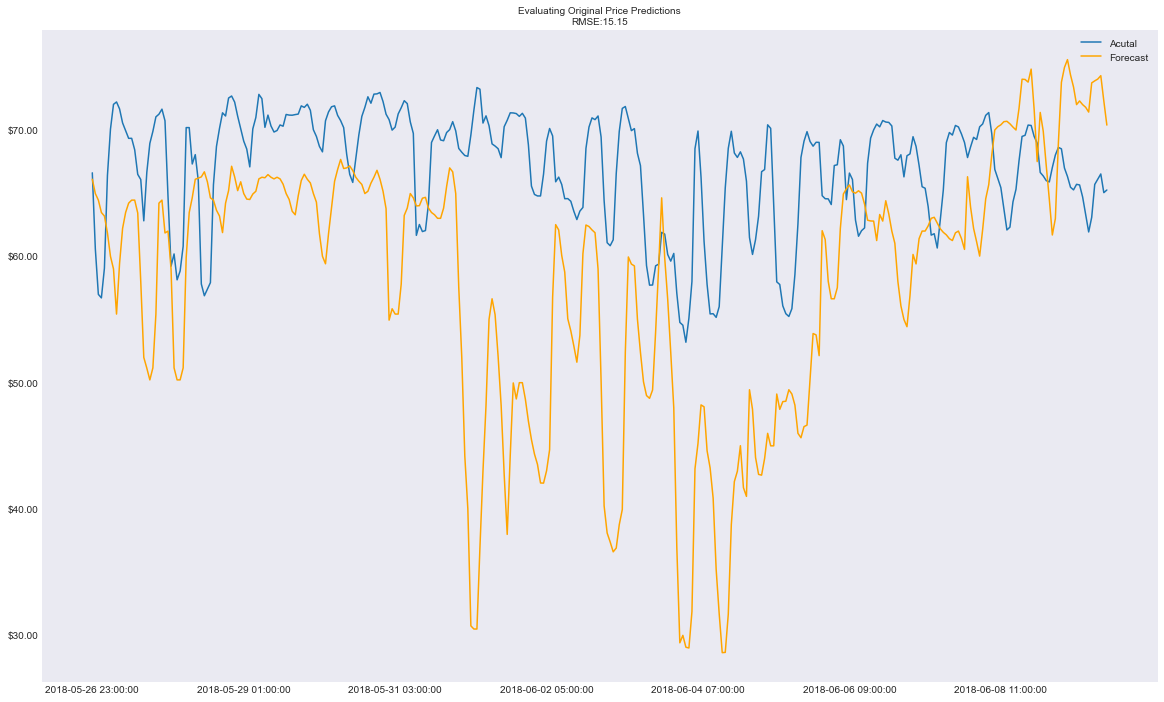

In [7]:
#Read in model_performance to capture metrics and timeseries_plot to plot timeseries
from TimeSeriesStats import model_performance
from TimeseriesPlotter import timeseries_plot

#Capture predictions
predictions = price_test.values
actual = X_test['price actual'].values

#Evaluate price preditions
metrics = model_performance(predictions, actual, 'Original Price Model')

#Create fig
f, ax = plt.subplots(figsize = (20,12))

#Plot original data
timeseries_plot(X_test['price actual'][:24*14], ax = ax)
timeseries_plot(price_test[:24*14],title='Evaluating Original Price Predictions\nRMSE:{}'.format(round(metrics['RMSE'],2)), color = 'orange', ax = ax)

###Set plot aesthetics###
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax.legend(['Acutal', 'Forecast'], shadow = True);

## Univariate Analysis

**Prepare data for univariate analysis**

In [8]:
#Set Univariate variable for model training
X_train_univariate = X_train['price actual stationary']

#Set actual as target
actual = X_test['price actual']

#Check
print('Univariate training data shape{}\nLabel shape{}\n'.format(X_train_univariate.shape,actual.shape))
display(X_train_univariate.head())

Univariate training data shape(29789,)
Label shape(5257,)



date_time
2015-01-01 12:00:00   -5.750750
2015-01-01 13:00:00   -3.198368
2015-01-01 14:00:00   -2.233563
2015-01-01 15:00:00   -3.437243
2015-01-01 16:00:00   -1.000426
Name: price actual stationary, dtype: float64

### Holt-Winters Exponential Smoothing

**Build HW Model**

In [9]:
#Import holt winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import HoltWintersResults

#Init model
holt_winters = ExponentialSmoothing(X_train_univariate.values,seasonal='add', seasonal_periods=12).fit(smoothing_level=0.8, smoothing_slope=0.2)

#Make predictions
holt_preds = holt_winters.forecast(len(actual))

**Convert predictions back to proper scale**

In [10]:
#Store predictions and test values in a dataframe
evaluate_hw = pd.DataFrame(holt_preds, index=actual.index)
evaluate_hw.columns = ['hw_preds']
evaluate_hw['actual'] = actual.values

#Add seasonal and trend components to hw_preds
evaluate_hw['adjusted_preds'] = evaluate_hw['hw_preds'] + X_test['price actual season'] + X_test['price actual trend']

#Check
display(evaluate_hw)

,hw_preds,actual,adjusted_preds
date_time,,,
2018-05-26 14:00:00,0.654029,66.61,68.141673
2018-05-26 15:00:00,-1.049062,60.59,66.803892
2018-05-26 16:00:00,-4.007850,56.99,65.472277
2018-05-26 17:00:00,-7.100664,56.71,64.817375
2018-05-26 18:00:00,-9.101818,59.06,63.881622
...,...,...,...
2018-12-31 07:00:00,-3.108427,60.70,68.332649
2018-12-31 08:00:00,-1.765656,66.64,69.214366
2018-12-31 09:00:00,0.213476,70.33,70.465094


**Evaluate Holt Winter's Predictions**

HW Performance Metrics
MAE:4.945704618595356
MAPE:0.07101842138388184
MSE:36.79915671838181
RMSE:6.066230849413976


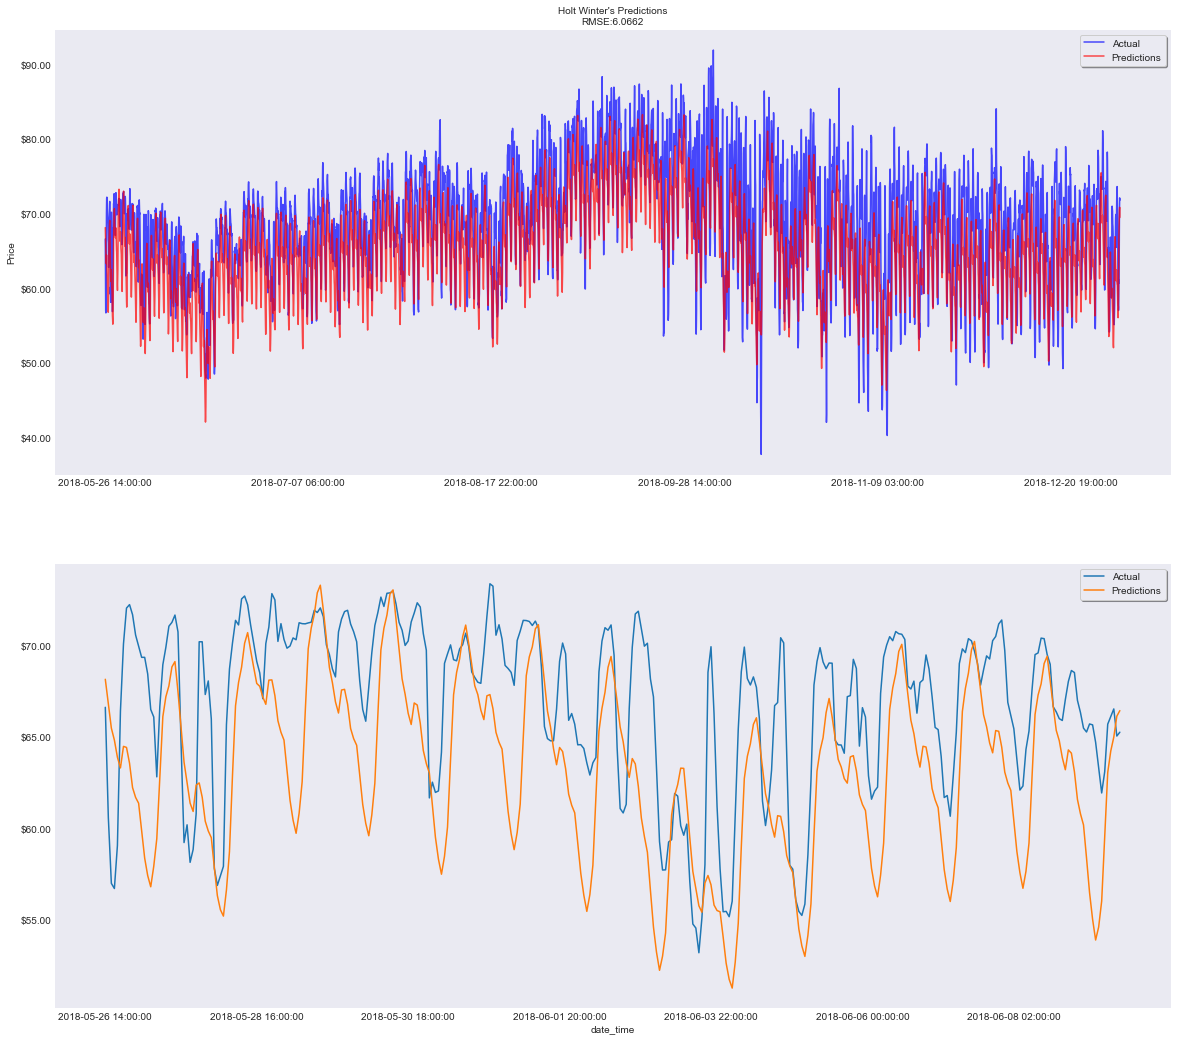

In [11]:
#Evaluate metrics
hw_metrics = model_performance(evaluate_hw.adjusted_preds.values, evaluate_hw.actual.values, 'HW')

#Create fig to plot data to evaluate fit
f,ax = plt.subplots(2,1,figsize = (20,18))

#Plot predictions against test data
timeseries_plot(evaluate_hw.actual, ax=ax[0], color = 'blue',alpha=.7)
timeseries_plot(evaluate_hw.adjusted_preds, ax=ax[0], 
                title ='Holt Winter\'s Predictions\nRMSE:{}'.format(round(hw_metrics['RMSE'],4)),
                title_dict=title_dict,ylabel='Price', color = 'red',label_dict=label_dict,alpha=.7)

###Set plot aesthetics**
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].legend(['Actual','Predictions'], frameon = True, shadow = True)

#Plot predictions against test data(zoomed)
evaluate_hw.actual[:24*14].plot( ax=ax[1])
evaluate_hw.adjusted_preds[:24*14].plot( ax=ax[1])


ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[1].legend(['Actual','Predictions'], frameon = True, shadow = True)

### ARMA Model 

**PACF and ACF of Stationary Target**

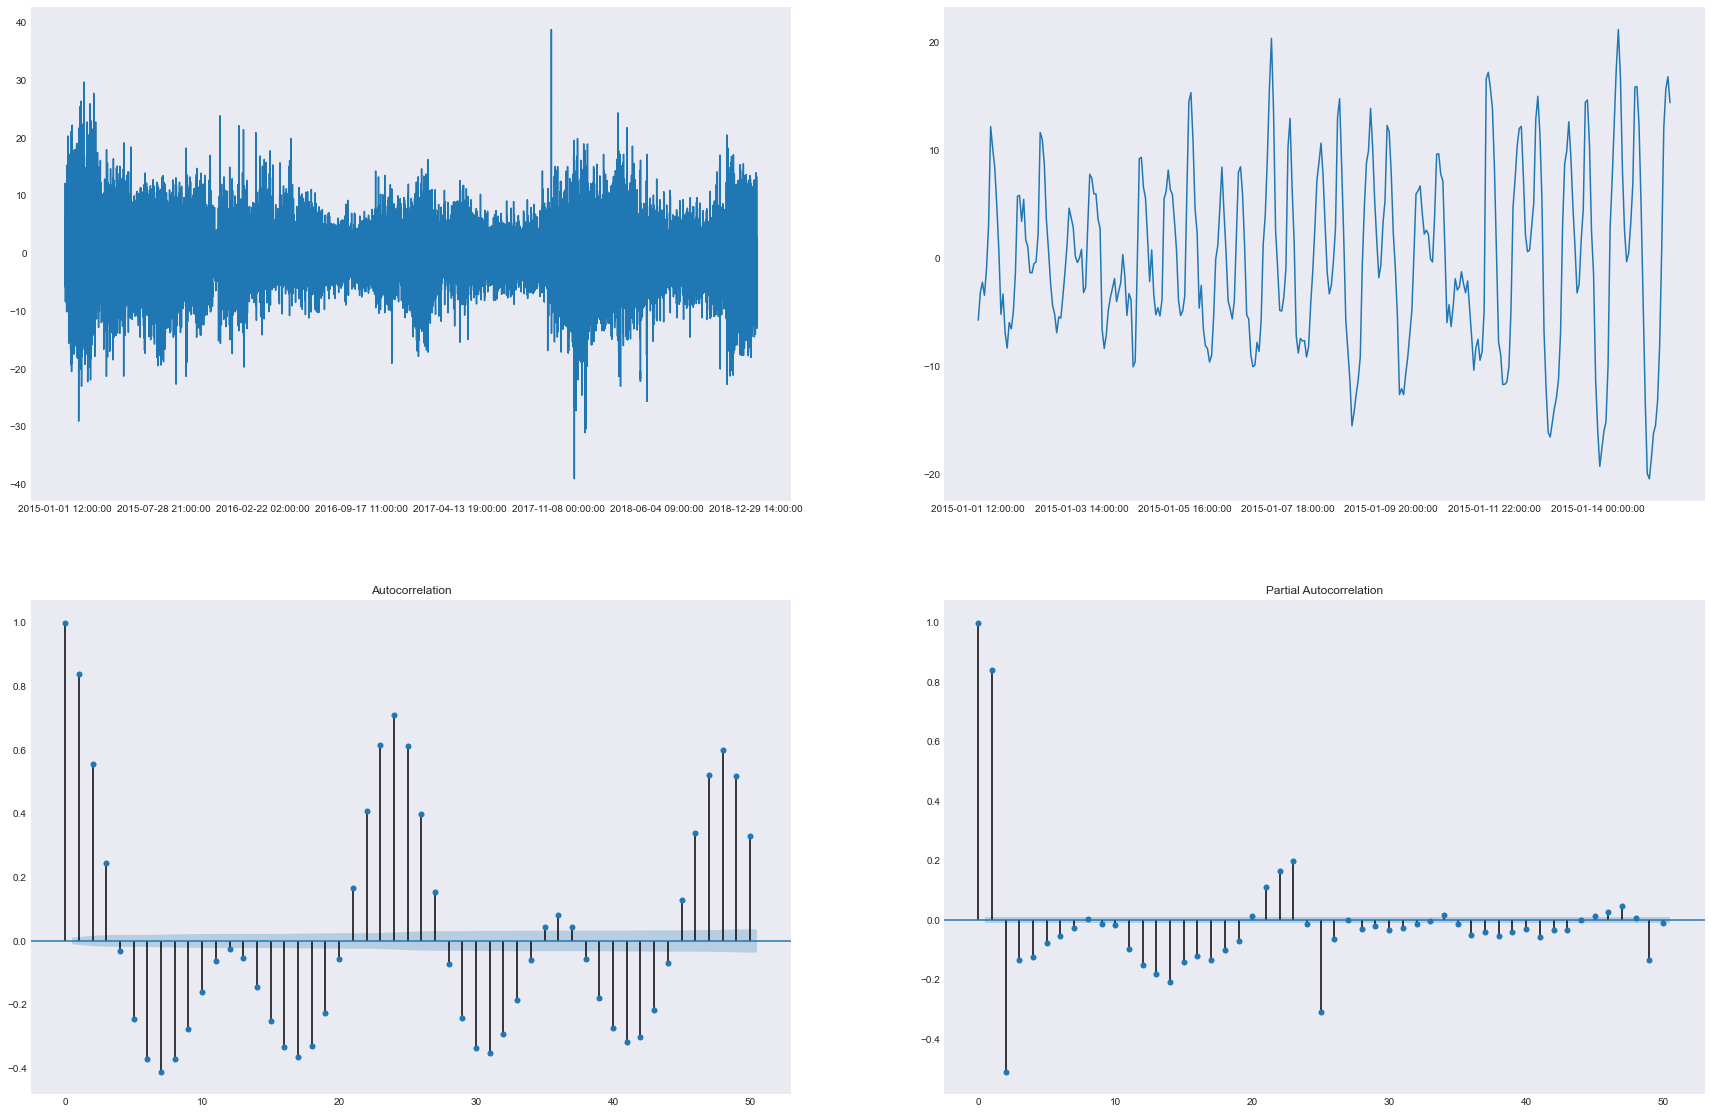

In [26]:
#Set path
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\02_Data_Processing'

#Read in image
Image(filename= viz_path + '/stationary_target_PACF_ACF.png', height=1300, width=1500)

**Build ARMA Model**

In [13]:
#Import library
from statsmodels.tsa.arima_model import ARIMA

#Build, fit, and view ARMA summary
model = ARIMA(X_train_univariate.values, order=(2,0,1))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                29789
Model:                     ARMA(2, 1)   Log Likelihood              -71550.292
Method:                       css-mle   S.D. of innovations              2.672
Date:                Sat, 27 Jun 2020   AIC                         143110.585
Time:                        13:08:41   BIC                         143152.094
Sample:                             0   HQIC                        143123.908
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.046      0.018      0.986      -0.090       0.092
ar.L1.y        1.5549      0.008    184.471      0.000       1.538       1.571
ar.L2.y       -0.7434      0.007   -109.286      0.000      -0.757      -0.730
ma.L1.y       -0.4345      0.013    -34.227      0.000      -0.459      -0.410
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0459           -0.5014j            1.1599           -0.0711
AR.2            1.0459           +0.5014j            1.1599            0.0711
MA.1            2.3013           +0.0000j            2.3013            0.0000
-----------------------------------------------------------------------------
"""

**Make and convert ARMA forecasts to proper scale**

In [14]:
#Create forecast
fc,se,conf = model_fitted.forecast(len(actual))

#Create arma_forecasts df to contain forecasts, upper/lower confidence intervals
arma_forecasts = pd.DataFrame(fc, index=actual.index)
arma_forecasts.columns = ['forecasts']
arma_forecasts['upper_conf']= conf[:,1] #add upper and lower confidence intervals to predictions
arma_forecasts['lower_conf'] =  conf[:,0]

#For loop converts columns in arma_forecasts to proper scale
for col in arma_forecasts.columns:
    arma_forecasts[col + ' adjusted'] = arma_forecasts[col] + X_test['price actual season'] + X_test['price actual trend']

#Add target to arma_forecasts and sort columns
arma_forecasts['actual']=actual
arma_forecasts = arma_forecasts.reindex(sorted(arma_forecasts.columns), axis=1)

#Check
display(arma_forecasts.head())

,actual,forecasts,forecasts adjusted,lower_conf,lower_conf adjusted,upper_conf,upper_conf adjusted
date_time,,,,,,,
2018-05-26 14:00:00,66.61,1.305928,68.793572,-3.931651,63.555993,6.543506,74.031150
2018-05-26 15:00:00,60.59,1.058526,68.911480,-6.806994,61.045960,8.924047,76.777001
2018-05-26 16:00:00,56.99,0.675310,70.155437,-8.770823,60.709304,10.121444,79.601571
2018-05-26 17:00:00,56.71,0.263348,72.181388,-9.907928,62.010112,10.434624,82.352664
2018-05-26 18:00:00,59.06,-0.092352,72.891088,-10.453821,62.529620,10.269116,83.252557


**Evaluate ARMA Forecasts**

ARIMA Performance Metrics
MAE:4.325886697302129
MAPE:0.06587730820723477
MSE:31.857276805700337
RMSE:5.644225084606419


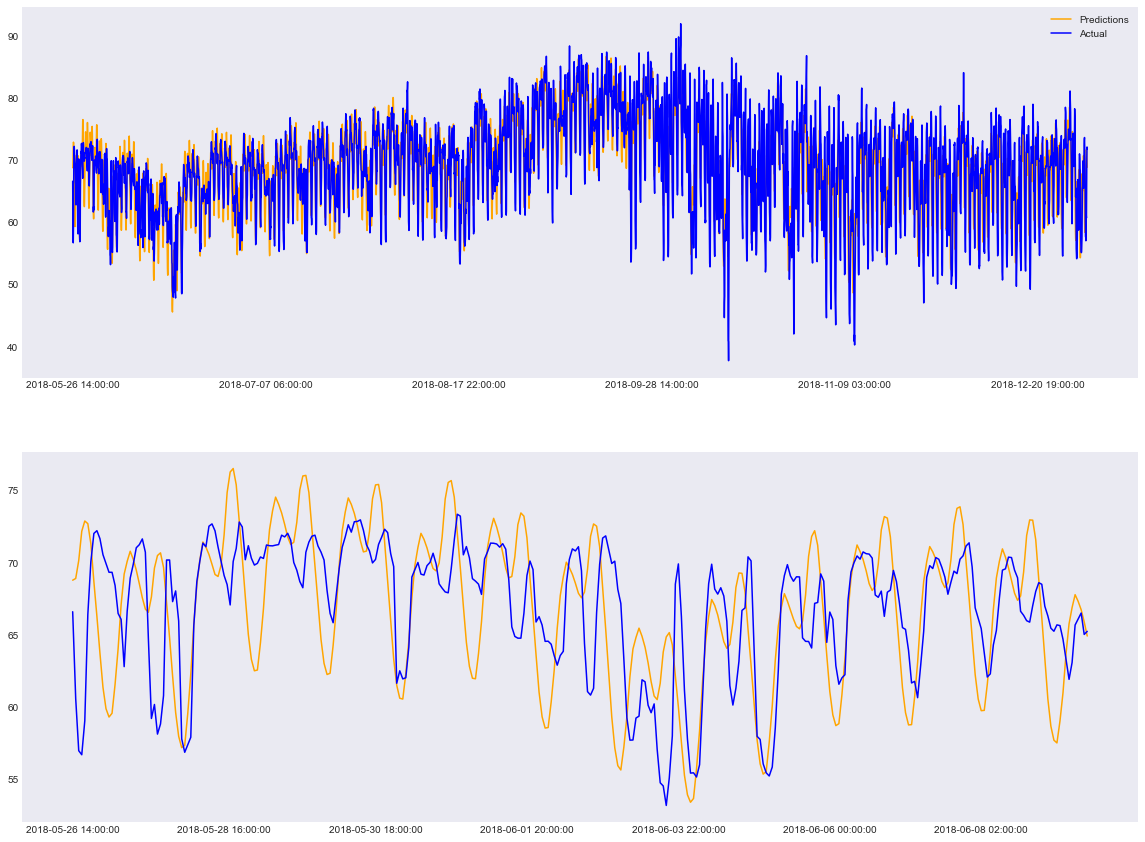

In [15]:
#Evaluate ARIMA's Performance
arima_metrics = model_performance(arma_forecasts['forecasts adjusted'].values,actual,'ARIMA')

#Set Figure
f, ax = plt.subplots(2,1,figsize = (20,15))

#Plot Forecasts
timeseries_plot(arma_forecasts['forecasts adjusted'], ax = ax[0], color = 'orange')
timeseries_plot(actual, ax = ax[0], color = 'blue')
ax[0].legend(['Predictions','Actual'])


timeseries_plot(arma_forecasts['forecasts adjusted'][:24*14], ax = ax[1],color = 'orange')
timeseries_plot(actual[:24*14], ax = ax[1],color = 'blue')

**Check Residuals**

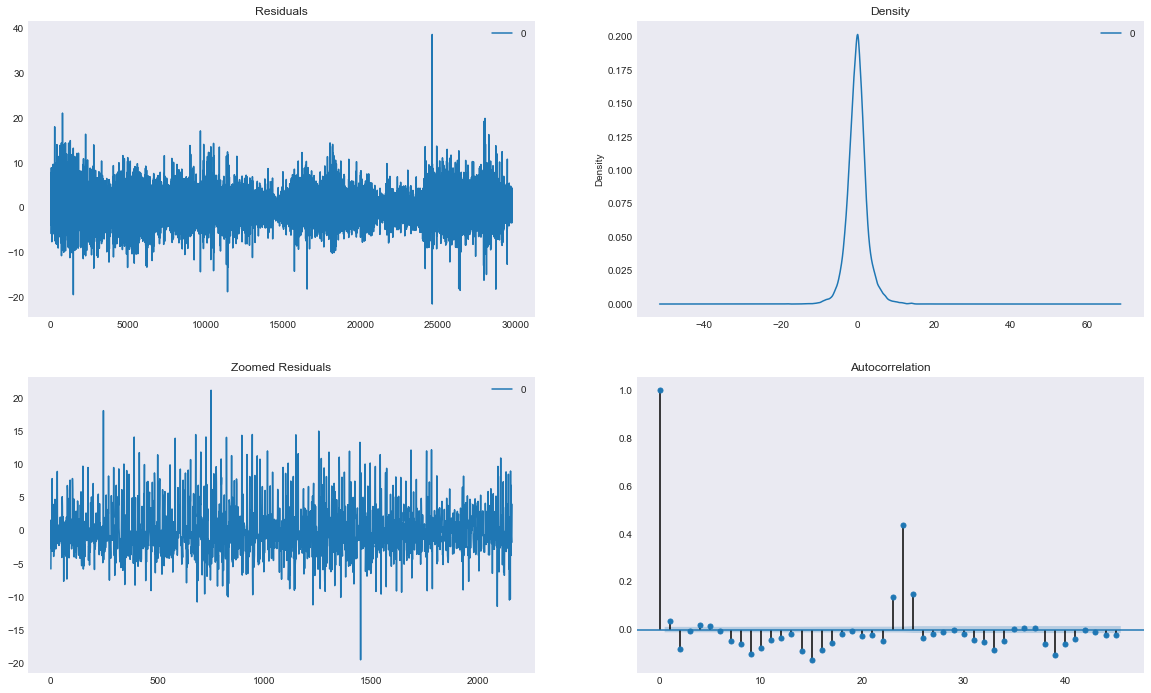

In [16]:
#Check residuals
from statsmodels.graphics.tsaplots import plot_acf


residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(2,2, figsize = (20,12))
residuals.plot(title="Residuals", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[0,1])
residuals[:24*90].plot(title="Zoomed Residuals", ax=ax[1,0])
plot_acf(residuals, ax=ax[1,1])

plt.show()

### XGBoost 

### Multivariate Analysis - Vector Autoregression

In [17]:
#Subset stationary features for multivariate analysis
X_train_multivariate = X_train.filter(regex='stationary')

#Check
print('Multivariate training data shape:{}'.format(X_train_multivariate.shape))

Multivariate training data shape:(29789, 5)


In [18]:
#Read in and init VARMAX
from statsmodels.tsa.api import VAR

#Init VAR model
model = VAR(X_train_multivariate)

#Find optimal value for P
display(model.select_order(maxlags=24).summary())

#Fit model with maxlags = 24
model_fitted = model.fit(24)

,AIC,BIC,FPE,HQIC
0,56.07,56.07,2.236e+24,56.07
1,50.20,50.21,6.360e+21,50.21
2,49.04,49.05,1.978e+21,49.04
3,48.99,49.02,1.894e+21,49.00
4,48.93,48.96,1.780e+21,48.94
5,48.90,48.94,1.724e+21,48.91
6,48.87,48.92,1.680e+21,48.89
7,48.85,48.90,1.643e+21,48.87
8,48.82,48.88,1.598e+21,48.84
9,48.79,48.86,1.554e+21,48.82


**Check for serial correlation**

In [19]:
#Import durbin_watson
from statsmodels.stats.stattools import durbin_watson

#Init durbin_watson and get serial correlation results
serial_corr = durbin_watson(model_fitted.resid)

#View results
for col,value in zip(X_train.columns, serial_corr):
    print(col, 'DW Statistic:', round(value,3))

generation fossil gas DW Statistic: 2.021
generation fossil gas season DW Statistic: 1.995
generation fossil gas stationary DW Statistic: 2.015
generation fossil gas trend DW Statistic: 2.02
generation fossil hard coal DW Statistic: 2.04


**Forecast Predictions w/ VAR**

In [20]:
#Prepare input data, making sure to invert time series
lag_order = model_fitted.k_ar
var_input_data = X_train_multivariate.values[-lag_order:]

#Make forecast
forecast = model_fitted.forecast(var_input_data, steps = len(X_test))

In [21]:
X_test.head()

,generation fossil gas,generation fossil gas season,generation fossil gas stationary,generation fossil gas trend,generation fossil hard coal,generation fossil hard coal season,generation fossil hard coal stationary,generation fossil hard coal trend,generation hydro pumped storage consumption,generation hydro pumped storage consumption season,generation hydro pumped storage consumption stationary,generation hydro pumped storage consumption trend,price actual,price actual season,price actual stationary,price actual trend,total load actual,total load actual season,total load actual stationary,total load actual trend
date_time,,,,,,,,,,,,,,,,,,,,
2018-05-26 14:00:00,6048.0,258.836710,24.309123,5764.854167,4527.0,145.805831,-24.743331,4405.937500,194.0,-118.820125,129.695125,183.125000,66.61,0.535144,-0.877644,66.952500,27714.0,2141.914399,582.731434,24989.354167
2018-05-26 15:00:00,5663.0,334.864589,-418.343756,5746.479167,4094.0,146.633903,-439.425570,4386.791667,194.0,-115.247777,129.664444,179.583333,60.59,0.799412,-7.262954,67.053542,26342.0,1921.311927,-484.686927,24905.375000
2018-05-26 16:00:00,5466.0,472.511350,-730.323850,5723.812500,3676.0,178.528238,-872.340738,4369.812500,463.0,-163.521222,447.250389,179.270833,56.99,2.340335,-12.490127,67.139792,25461.0,1993.187712,-1355.937712,24823.750000
2018-05-26 17:00:00,5289.0,651.289261,-1068.997594,5706.708333,3610.0,226.480108,-968.334274,4351.854167,492.0,-240.648377,552.085877,180.562500,56.71,4.743248,-15.208039,67.174792,25063.0,2323.286685,-2007.453351,24747.166667
2018-05-26 18:00:00,5351.0,770.538148,-1106.621481,5687.083333,3880.0,260.865653,-712.198986,4331.333333,280.0,-308.219652,402.886319,185.333333,59.06,5.793649,-13.923441,67.189792,24944.0,2489.289653,-2213.977153,24668.687500


**Convert forecasts and evaluate performance on target**

In [22]:
#Create a dataframe of forecast values
var_forecasts = pd.DataFrame(forecast, index=actual.index[-len(actual):], columns=X_train_multivariate.columns)

#Subset trend and season values from X_test
trend_season = X_test.filter(regex='season|trend')

#Concatenate and sort columns alphabetically
var_forecasts = pd.concat([var_forecasts,trend_season], axis = 1)
var_forecasts = var_forecasts.reindex(sorted(var_forecasts.columns), axis = 1)

#Convert predictions on price actual
var_forecasts['price actual predictions'] = var_forecasts['price actual stationary'] + var_forecasts['price actual season'] + var_forecasts['price actual trend']

#Check
display(var_forecasts.head())

,generation fossil gas season,generation fossil gas stationary,generation fossil gas trend,generation fossil hard coal season,generation fossil hard coal stationary,generation fossil hard coal trend,generation hydro pumped storage consumption season,generation hydro pumped storage consumption stationary,generation hydro pumped storage consumption trend,price actual season,price actual stationary,price actual trend,total load actual season,total load actual stationary,total load actual trend,price actual predictions
date_time,,,,,,,,,,,,,,,,
2018-05-26 14:00:00,258.836710,-129.228745,5764.854167,145.805831,4.812374,4405.937500,-118.820125,145.799430,183.125000,0.535144,0.318547,66.952500,2141.914399,852.693296,24989.354167,67.806191
2018-05-26 15:00:00,334.864589,-211.953160,5746.479167,146.633903,-80.643442,4386.791667,-115.247777,207.958736,179.583333,0.799412,-1.952381,67.053542,1921.311927,521.474252,24905.375000,65.900573
2018-05-26 16:00:00,472.511350,-219.275990,5723.812500,178.528238,-114.083722,4369.812500,-163.521222,304.135531,179.270833,2.340335,-4.388437,67.139792,1993.187712,-35.160998,24823.750000,65.091690
2018-05-26 17:00:00,651.289261,-277.126660,5706.708333,226.480108,-165.178367,4351.854167,-240.648377,334.073717,180.562500,4.743248,-5.953971,67.174792,2323.286685,-775.352274,24747.166667,65.964069
2018-05-26 18:00:00,770.538148,-298.615695,5687.083333,260.865653,-199.575195,4331.333333,-308.219652,300.449019,185.333333,5.793649,-6.359934,67.189792,2489.289653,-1307.041700,24668.687500,66.623506


**Plot Forecasts to see fit**

VAR Performance Metrics
MAE:4.265074643430418
MAPE:0.06495307878186127
MSE:31.180247664444657
RMSE:5.583927619914558


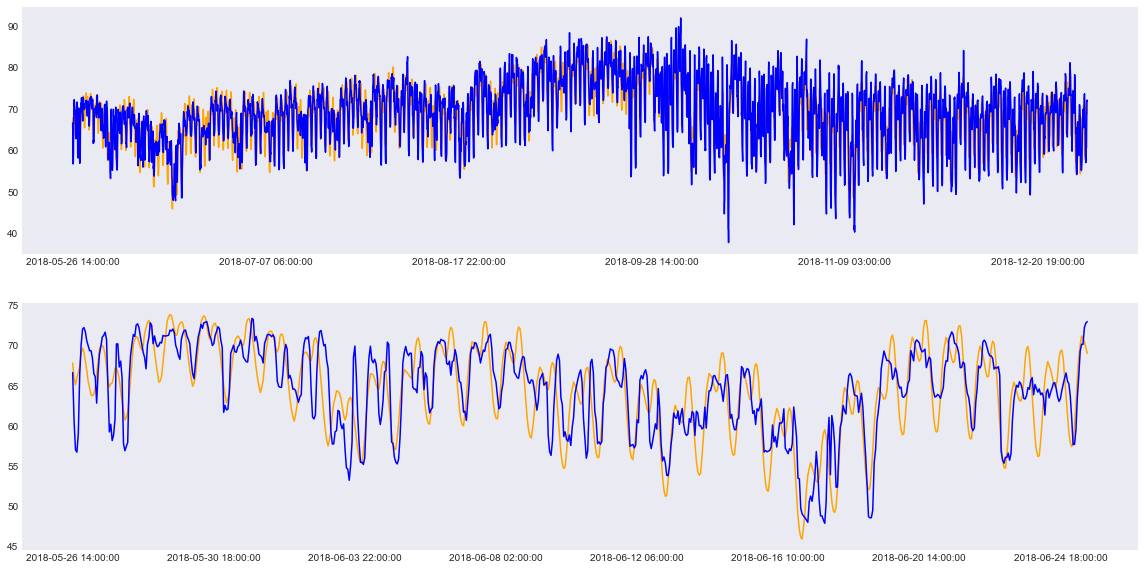

In [23]:
#Evaluate VAR performance on price actual predictions
var_metrics = model_performance(var_forecasts['price actual predictions'].values, actual.values, 'VAR')

#Create figure
f, ax = plt.subplots(2,1,figsize = (20,10))

#Plot predictions
timeseries_plot(var_forecasts['price actual predictions'], ax = ax[0], color = 'orange')
timeseries_plot(X_test['price actual'], ax = ax[0], color = 'blue')

timeseries_plot(var_forecasts['price actual predictions'][:24*30], ax = ax[1], color = 'orange')
timeseries_plot(X_test['price actual'][:24*30], ax = ax[1], color = 'blue')


## Multivariate XGBoost

In [27]:
#Read in training and test data
Xgbr_train = pd.read_csv(path + '/2020_0627_XGTraining_Data.csv', index_col=0)
Xgbr_test = pd.read_csv(path + '/2020_0627_XGTest_Data.csv', index_col=0)